In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import pandas_datareader as web

%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [2]:
#input data
company_tickers = 'AMZN'
start_date = '2015-10-31'
end_date = '2020-10-31'

df = web.DataReader(company_tickers, 'yahoo', start_date, end_date)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-02,628.630005,620.409973,627.130005,628.349976,2816500,628.349976
2015-11-03,629.890015,622.000000,629.530029,625.309998,3246900,625.309998
2015-11-04,645.929993,627.349976,627.760010,640.950012,4840500,640.950012
2015-11-05,657.000000,643.090027,647.099976,655.650024,4723800,655.650024
2015-11-06,662.260010,652.000000,655.000000,659.369995,4092200,659.369995


In [3]:
df.info

<bound method DataFrame.info of                    High          Low         Open        Close   Volume  \
Date                                                                      
2015-11-02   628.630005   620.409973   627.130005   628.349976  2816500   
2015-11-03   629.890015   622.000000   629.530029   625.309998  3246900   
2015-11-04   645.929993   627.349976   627.760010   640.950012  4840500   
2015-11-05   657.000000   643.090027   647.099976   655.650024  4723800   
2015-11-06   662.260010   652.000000   655.000000   659.369995  4092200   
...                 ...          ...          ...          ...      ...   
2020-10-26  3282.979980  3153.300049  3198.739990  3207.040039  5901200   
2020-10-27  3291.659912  3211.300049  3224.939941  3286.330078  4291000   
2020-10-28  3264.020020  3162.469971  3249.300049  3162.780029  5588300   
2020-10-29  3257.250000  3164.000000  3201.270020  3211.010010  6596500   
2020-10-30  3167.000000  3019.000000  3157.750000  3036.149902  8386

In [4]:
#Check for missing data
print(df.isnull().sum())

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


In [5]:
#Great we have no missing data. Obtain a summary statistics on the data
df.reset_index(inplace=True)
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,1489.314765,1456.272613,1473.895259,1473.539364,4.424853e+06,1473.539364
std,709.896603,688.082285,699.813763,699.022856,2.150912e+06,699.022856
min,493.500000,474.000000,478.010010,482.070007,8.813000e+05,482.070007
25%,841.829987,830.755005,836.295013,836.635010,2.927050e+06,836.635010
50%,1573.849976,1522.510010,1550.000000,1544.930054,3.876400e+06,1544.930054
75%,1863.304993,1826.875000,1843.929993,1847.539978,5.271050e+06,1847.539978
max,3552.250000,3486.689941,3547.000000,3531.449951,1.656500e+07,3531.449951


##Exploratory Analysis

Text(0, 0.5, 'Close Price US($)')

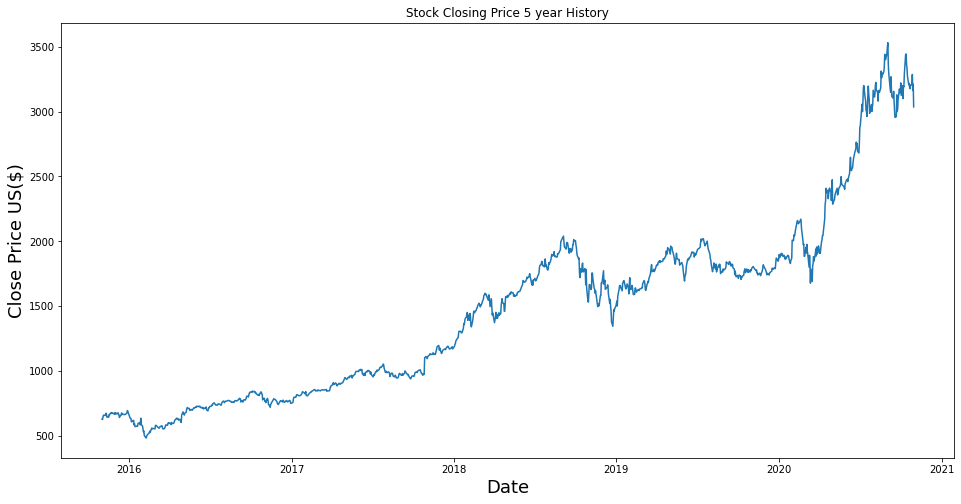

In [7]:
#Plot a historical view of the closing price
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Stock Closing Price 5 year History')
plt.title('Stock Closing Price 5 year History')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price US($)',fontsize=18)

##Check for Correlation

In [9]:
corr = df.corr(method='pearson')
corr

,High,Low,Open,Close,Volume,Adj Close
High,1.000000,0.999441,0.999672,0.999615,0.158066,0.999615
Low,0.999441,1.000000,0.999549,0.999642,0.135995,0.999642
Open,0.999672,0.999549,1.000000,0.999220,0.148945,0.999220
Close,0.999615,0.999642,0.999220,1.000000,0.146642,1.000000
Volume,0.158066,0.135995,0.148945,0.146642,1.000000,0.146642
Adj Close,0.999615,0.999642,0.999220,1.000000,0.146642,1.000000


<AxesSubplot:>

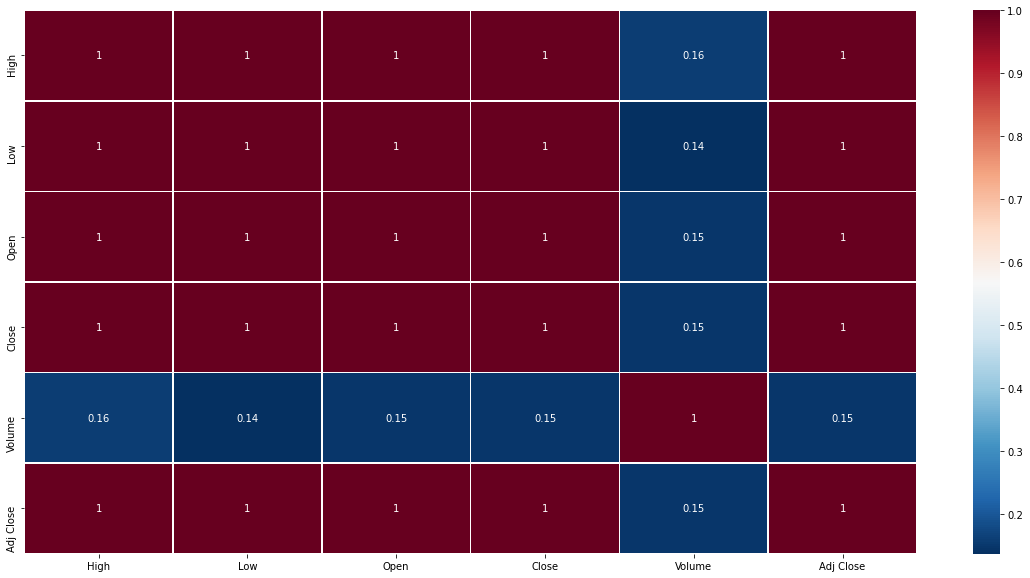

In [10]:
sb.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns,
 cmap='RdBu_r', annot=True, linewidth=0.5)

#Sort the dataset on date time and filter “Date” and “Close” columns:

In [11]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    
training_data_len = int(np.ceil(len(df) * .8 ))

#Normalize the new filtered dataset:

In [14]:
new_dataset.reset_index(inplace=True)

In [15]:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:training_data_len,:]
valid_data=final_dataset[training_data_len:,:]


scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


In [16]:
#Build and train the LSTM model
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

948/948 - 24s - loss: 7.8919e-04


In [17]:
#Take a sample of a dataset to make stock price predictions using the LSTM model.

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

lstm_model.save("saved_model.h5")

## Visualize the predicted stock costs.

In [25]:
df['Date'].head(1)


Date
2015-11-02   2015-11-02
Name: Date, dtype: datetime64[ns]

<ipython-input-26-8433ef4c48b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price


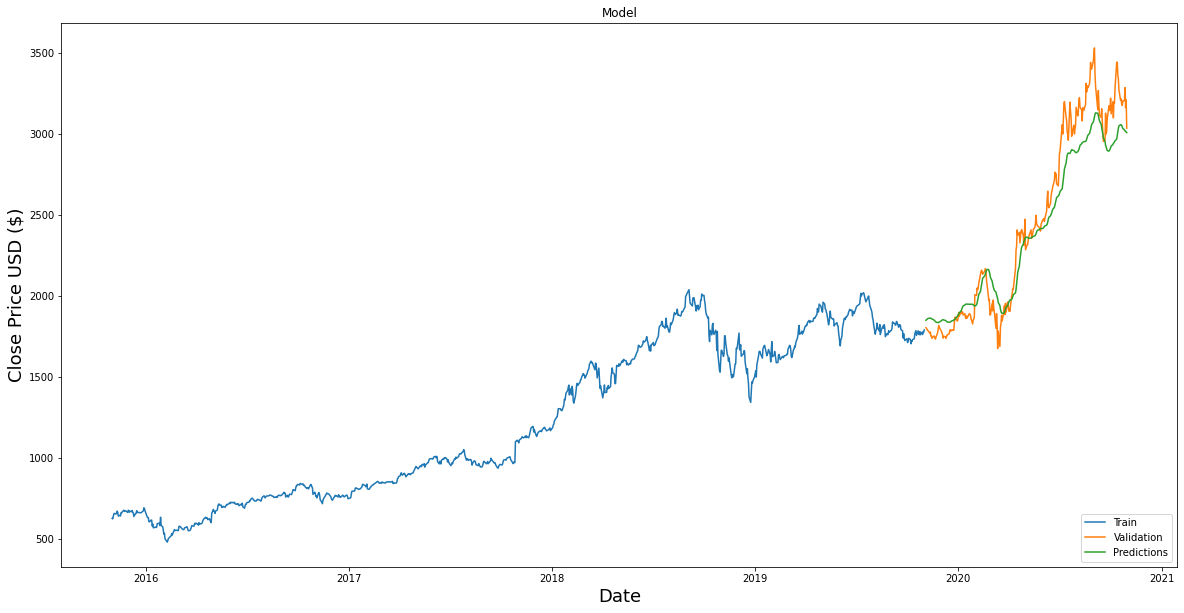

In [26]:
train_data=new_dataset[:training_data_len]
valid_data=new_dataset[training_data_len:]
valid_data['Predictions'] = predicted_closing_price


plt.plot(train_data["Close"])
plt.plot(valid_data["Close"])
plt.plot(valid_data['Predictions'])

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

###Print the valid and predicted prices

In [27]:
#Show the valid and predicted prices
valid_data

,Close,Predictions
Date,,
2019-11-04,1804.66,1850.718994
2019-11-05,1801.71,1853.922852
2019-11-06,1795.77,1857.368042
2019-11-07,1788.2,1860.398682
2019-11-08,1785.88,1862.549194
...,...,...
2020-10-26,3207.04,3025.773926
2020-10-27,3286.33,3018.728516
2020-10-28,3162.78,3017.698486


##Conculsion

In this project, the following was accomplished: 

    1. Data extraction from the web using pandas_datareader.
    2. Data exploration  
    3. Python seaborn library to visualize correlation heatmap
    4. Pearson correlation
    5. Feature plotting against dependent output using Matplotlib.
    6. Plotting of Actual value with the Predicted value.
       